In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import quantum as qm
import asymmetric as asym
import scipy.sparse.linalg as spla
import importlib
importlib.reload(asym)
from scipy.special import  comb

# Block Diagonal

In [2]:
L = 7; end = 20; n = 3; field_strength = 1

_,x_list,y_list, z_list = qm.get_sigma_lists(L, half=False)
H = asym.dense_H(L)
Z0 = z_list[0]
if (not field_strength is None):
    h = field_strength/2 # Take into account spin-1/2
    H = H + qm.get_local_field(z_list, np.random.rand(L)*2*h - h)

In [3]:
Hlist  = asym.mat2list(H)
Zlists = [asym.mat2list(Z) for Z in z_list]
Z0list = Zlists[0]

In [27]:
def zotoc_mat_exact(L, Hlist, Z0list, Zlists, end=20, n=3):
    tot = end*n
    OTOCs = np.zeros((L,tot))
    for T in range(tot):
        t = T/n
        Ulist    = [spla.expm(-1j*H*t) for H in Hlist]
        Ulistinv = [spla.expm( 1j*H*t) for H in Hlist]
        Z0tlist  = [Ui@Z0@U for (Ui, Z0, U) in zip(Ulistinv, Z0list, Ulist)]

        for i in range(L):
            corr = [Z0t@Zi@Z0t@Zi for (Z0t, Zi) in zip(Z0tlist, Zlists[i])]
            OTOCs[i, T] = 1-sum([c.diagonal().sum().real for c in corr])/2**L
    return OTOCs
OTOCs = zotoc_mat_exact(L, Hlist, Z0list, Zlists, end=20, n=3)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


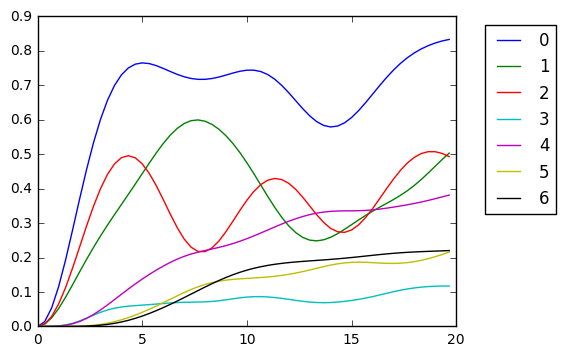

In [28]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

In [6]:
vec = qm.get_vec_Haar(2**L)
vecs = asym.arr2list(vec)

# expm_mult, vectors

In [33]:
def zotoc_vec_expm(L, Hlist, Z0list, vecs, Zlists, end=20, n=3):
    e = spla.expm_multiply
    tot = end*n
    OTOCs = np.zeros((L,tot))
    for T in range(tot):
        t = T/n
        vbs  = [e(1j*H*t, Z0@e(-1j*H*t, vec)) for (H, Z0, vec) in zip(Hlist, Z0list, vecs)]

        for i in range(L):
            v1s = [e(1j*H*t, Z0@e(-1j*H*t, Zi@vec)) for (H, Z0, vec, Zi) in zip(Hlist, Z0list, vecs, Zlists[i])]
            v2s = [Zi@vb for (Zi, vb) in zip(Zlists[i], vbs)]
            OTOCs[i, T] = 1-sum([v2.conj().T@v1 for (v1, v2) in zip(v1s, v2s)]).real
    return OTOCs

In [ ]:
OTOCs = zotoc_vec_expm(L, Hlist, Z0list, vecs, Zlists, end=20, n=3)

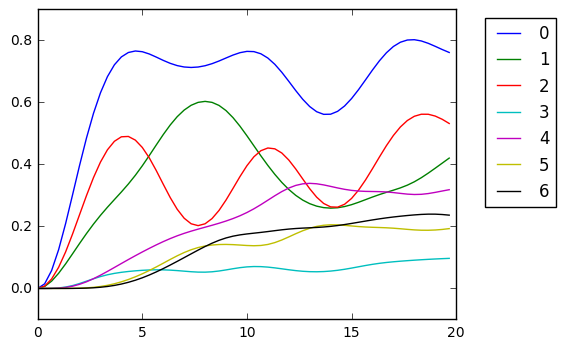

In [24]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Hybrid Method

In [29]:
cutoff = 20
s_Hlist  =  [H for H in Hlist  if H.shape[0]<cutoff]
s_Zlists = [[Z for Z in z_list if Z.shape[0]<cutoff] for z_list in Zlists]
s_Z0list =  [Z for Z in Z0list if Z.shape[0]<cutoff]

l_Hlist  =  [H for H in Hlist  if H.shape[0]>=cutoff]
l_Zlists = [[Z for Z in z_list if Z.shape[0]>=cutoff] for z_list in Zlists]
l_Z0list =  [Z for Z in Z0list if Z.shape[0]>=cutoff]
l_vecs  =   [v for v in vecs   if len(v)>=cutoff]

In [31]:
OTOCs = zotoc_mat_exact(L, s_Hlist, s_Z0list, s_Zlists, end=20, n=3) + \
        zotoc_vec_expm( L, l_Hlist, l_Z0list, l_vecs, l_Zlists)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


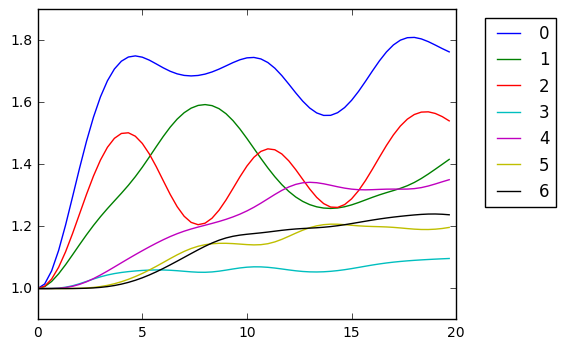

In [32]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

In [ ]:
d = 15
for l in range(d):
    print